# Red Giant Mode fitting

Start with 1 RG star chosen at random.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

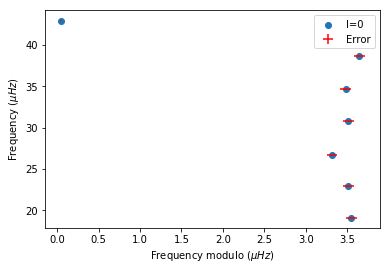

In [113]:
ID = 7741179 # Use ID to choose star
output = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, index_col=0)  #import output data
modes = pd.read_csv('RGdata/modes_'+str(ID)+'.csv', delim_whitespace=False, header=0)
numax_obs = float(output.loc[output.ID == ID].Numax)
numax_obs_err = float(output.loc[output.ID == ID].Numax_err)
dnu_obs = float(output.loc[output.ID == ID].Dnu_median)
dnu_obs_err = float(output.loc[output.ID == ID].Dnu_median_err)
l0modes = pd.DataFrame([modes.f0, modes.f0_err])
l0modes = l0modes.T
plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'l=0')  
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()
#plt.xlim(3.0, dnu_obs)

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [94]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

In [166]:
n = np.arange(3,10)
print(n)
epsilon = 1.85
nmax = numax_obs/dnu_obs - epsilon
k = 0.08
A = 0.9
w = 1.2
tau = 7
phi = 0
f = model(n, dnu_obs, nmax, epsilon, k, A, w, tau, phi)

[3 4 5 6 7 8 9]


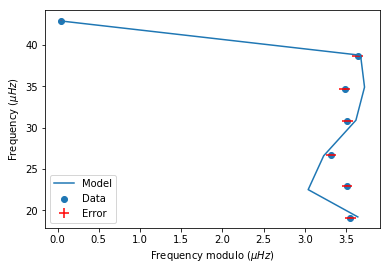

In [167]:
plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()

In [153]:
code = '''
data {
    int N;
    real n_guess[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {   
    real n[N];
    real dnu;
    real epsilon10;
    real<lower = 0> nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0, upper = 1.5> w;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    n ~ normal(n_guess, 5);
    n ~ uniform(0, 20);
    for (i in 1:N){
        mod[i] = (n[i] + epsilon10/10) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon10 ~ normal(14.92, 0.05);
    epsilon10 ~ uniform(0.00, 20.00);
    nmax ~ normal(22, 2);
    k ~ lognormal(log(0.1), 0.3);
    A ~ lognormal(log(1.0), 0.4);
    w ~ normal(1.0, 0.5);
    tau ~ normal(10, 10);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd1e8427f9287e750bc7ea9f2ae8f38b NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpis33uaai/stanfit4anon_model_fd1e8427f9287e750bc7ea9f2ae8f38b_7232932004281522475.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [155]:
data = {'N': len(l0modes.f0), 'freq': l0modes.f0, 'freq_err': l0modes.f0_err, 
        'dnu_guess': dnu_obs, 'n_guess': np.arange(3,10)}
#start = {'dnu': dnu, 'epsilon10': 10.00, 'nmax': nmax_guess, 'k': 0.1, 'A': 1.0, 'w': 0.8, 'phi': 2.0, 'tau': 50}
nchains=4
fit = sm.sampling(data=data, iter=5000, chains=nchains) # init=[start for n in range(nchains)])

RuntimeError: Initialization failed.

In [ ]:
fit.plot()
plt.show()

In [ ]:
print(fit)

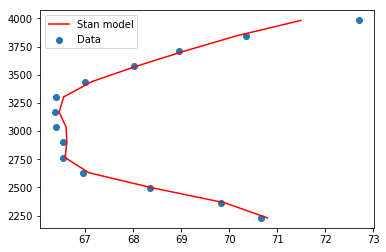

In [12]:
stanfit = model(lmodes[0].n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon10'].mean()/10, fit['k'].mean(), fit['A'].mean(), fit['w'].mean(), fit['tau'].mean(), fit['phi'].mean())

plt.subplots()
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(stanfit % fit['dnu'].mean(), stanfit, label = 'Stan model', color = 'r')
plt.errorbar(lmodes[0].nu % 135.2, df.loc[(df.l == 0) & (df.n > 11)].nu,
             xerr=df.loc[(df.l == 0) & (df.n > 11)].sg_nu, zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)
plt.legend()

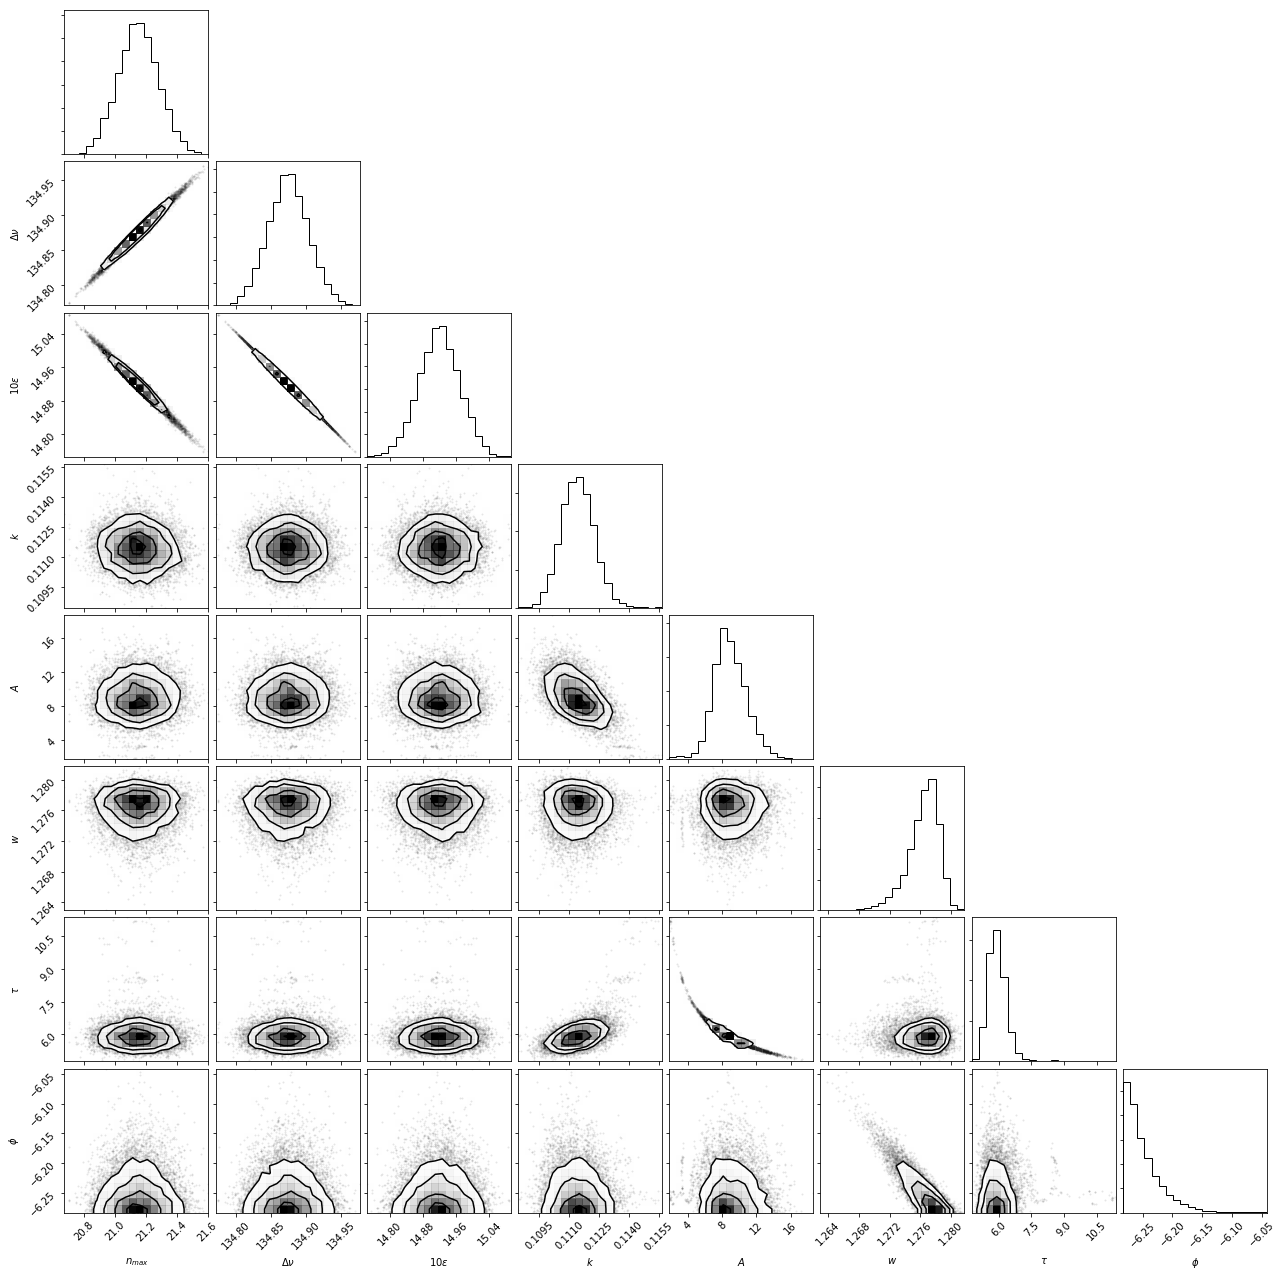

In [13]:
import corner
data = np.vstack([fit['nmax'], fit['dnu'], fit['epsilon10'], fit['k'], fit['A'], fit['w'], fit['tau'], fit['phi'],]).T
corner.corner(data, labels=[r'$n_{max}$', r'$\Delta\nu$', r'$10\epsilon$', r'$k$', r'$A$', r'$w$', r'$\tau$', r'$\phi$'])
plt.show()